# Torchscriptのローディングとテストデータでの推論結果評価

In [21]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torch.nn import Linear
from torchsummary import summary
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [22]:
model = torch.jit.load("../resources/model_torchscript_exp2.pth")

In [23]:
# ImageNetで訓練済の重みを使用する際は、訓練時に下記の正規化処理が入っているため、再現
# また入力サイズは224*224に固定する。
normalize = v2.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
test_transform = v2.Compose([v2.Resize(224, antialias=None), v2.CenterCrop(224), v2.ToTensor(),  normalize])

# 訓練データと、過学習モデルの採用を防ぐためのvalデータを用意しておきます。
test_dataset = ImageFolder("../resources/SDNET2018splitted/test", transform=test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

c:\Users\nwatt0\repos\imono-tutorial\.venv\lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [18]:
from sklearn.metrics import classification_report
from sklearn import metrics

model.eval()

preds = []
targets = []

for i, (data, target) in enumerate(test_dataloader):
    data, target = data.to("cpu"), target.to("cpu")

    pred = model(data)
    preds.extend([int(l.argmax()) for l in pred])
    targets.extend([int(t) for t in target])
    
print(metrics.accuracy_score(preds, targets))
print(metrics.average_precision_score(preds, targets))
print(metrics.balanced_accuracy_score(preds, targets))
print(metrics.recall_score(preds, targets, average='macro'))
print(metrics.recall_score(preds, targets, average='micro'))

0.8388878987702727
0.8792258790813318
0.6979596064498038
0.6979596064498038
0.8388878987702727


In [27]:
hfpreds = []
hftargets = []

with h5py.File("../resources/test_preprocessed_reduced.h5") as hf:
    hfdata = hf["data"]
    hflabel = hf["label"]
    
    batched_len = len(hf["data"])//32
    print(batched_len)
    for batchix in range(batched_len):
        data, target = hfdata[batchix*16:(batchix+1)*16], hflabel[batchix*16:(batchix+1)*16]
        data, target = torch.from_numpy(data), torch.from_numpy(target)
    
        pred = model(data)
        hfpreds.extend([int(l.argmax()) for l in pred])
        hftargets.extend([int(t) for t in target])

print(len(hfpreds))

print(metrics.accuracy_score(hfpreds, hftargets))
print(metrics.average_precision_score(hfpreds, hftargets))
print(metrics.balanced_accuracy_score(hfpreds, hftargets))
print(metrics.recall_score(preds, targets, average='macro'))
print(metrics.recall_score(preds, targets, average='micro'))

32
512
0.763671875
0.7778492356912168
0.6236833553172373
0.6979596064498038
0.8388878987702727


<Axes: >

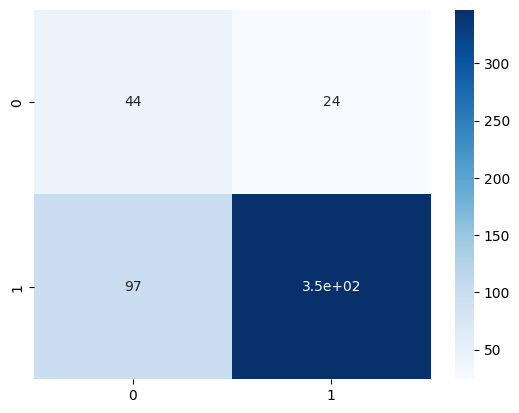

In [28]:
import seaborn as sns


cm = metrics.confusion_matrix(hftargets, hfpreds)
sns.heatmap(cm, annot=True, cmap='Blues')